In [139]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sim_tools.sim_baseline import sim_mpc
import sim_tools.dynamics as dynamics

state_bounds = np.array([np.pi/8, np.pi/8, np.pi/16, np.pi/16])

"""
User settings:
    Case 1: Angular deflection only, no initial momentum
    Case 2: Angular momentum only, no initial deflection
"""

CASE_ID = 2

N_points = 16
sg = np.array([0., 0., 0., 0.])

if CASE_ID == 1:
    q1 = np.linspace(-state_bounds[0], state_bounds[0], N_points)
    q2 = np.linspace(-state_bounds[1], state_bounds[1], N_points)
    q1_mesh, q2_mesh = np.meshgrid(q1, q2)
    x0 = np.concatenate((q1_mesh.reshape((-1,1)), q2_mesh.reshape((-1,1)), np.zeros((N_points**2,1)), np.zeros((N_points**2,1))), axis=1)
    MESH_X = q1_mesh
    MESH_Y = q2_mesh
    MESH_LABELS = ["q1", "q2"]

elif CASE_ID ==2:
    p1 = np.linspace(-state_bounds[2], state_bounds[3], N_points)
    p2 = np.linspace(-state_bounds[3], state_bounds[3], N_points)
    p1_mesh, p2_mesh = np.meshgrid(p1, p2)
    x0 = np.concatenate((np.zeros((N_points**2,1)), np.zeros((N_points**2,1)),p1_mesh.reshape((-1,1)), p2_mesh.reshape((-1,1))), axis=1)
    MESH_X = p1_mesh
    MESH_Y = p2_mesh
    MESH_LABELS = ["p1", "p2"]


errors = []
runtimes = []
t = np.linspace(0,10,100)
dt = t[1]-t[0]
Q = 1*np.eye(4)
R = 1*np.eye(2)
P = np.diag([1, 1, 1, 1])
N = 20
A,B = dynamics.linear_dynamics(dt)
state_hists = []

for ic_id, ic_val in enumerate(x0):
    state_hist, control_hist, runtime = sim_mpc(t, ic_val, sg, Q, R, P, N)
    errors.append(sg-state_hist[-1])
    state_hists.append(state_hist)
    runtimes.append(runtime)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
rms_errors = np.sqrt(np.sum(np.array(errors)**2, axis=1))
print(rms_errors.shape)
print("MPC Mean Runtime per scenario = ", np.mean(np.array(runtimes)), " seconds.")

(256,)
MPC Mean Runtime per scenario =  6.210805582813919  seconds.


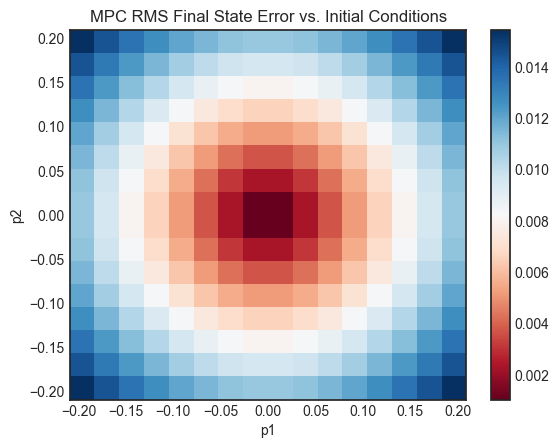

In [141]:
fig, ax = plt.subplots()
c = ax.pcolormesh(MESH_X, MESH_Y, rms_errors.reshape((N_points,N_points)), cmap="RdBu")
fig.colorbar(c, ax=ax)
ax.set_xlabel(MESH_LABELS[0])
ax.set_ylabel(MESH_LABELS[1])
ax.set_title("MPC RMS Final State Error vs. Initial Conditions")
plt.show()

In [142]:
import torch
from sim_tools.sim_neural import sim_neural 
from neural import neural_energy as enn
import torch.nn as nn

errors_neural = []
x0_torch = torch.Tensor(x0)
sg_torch = torch.Tensor(sg)
t_torch = torch.Tensor(t)
a,b = x0_torch.shape

hdim = 128 #126 256
V = nn.Sequential(
    nn.Linear(2, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim,2)
)
K = nn.Sequential(
    nn.Linear(4, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim, hdim),
    nn.ReLU(),
    nn.Linear(hdim,2),
    nn.ReLU()
)

f = enn.MirrorSystem(V,K)
model = enn.AugmentedMirror(f, enn.ControlEffort(f)).cpu()

global device
device = 'cpu'
model.load_state_dict(torch.load("models/deep_long.pth"))
model.eval().cpu()
t_torch = torch.linspace(0,10,100)
trajs, _, runtime_torch = sim_neural(model, x0_torch, sg_torch, t_torch)
print("ENN Runtime = ", runtime_torch, " seconds.")
print("ENN Runtime per scenario = ", runtime_torch/(N_points**2), " seconds.")

ENN Runtime =  1.890556812286377  seconds.
ENN Runtime per scenario =  0.00738498754799366  seconds.


In [143]:
errors_torch = np.array(trajs)[-1,:,:] - sg
rms_errors_torch = np.sqrt(np.sum(errors_torch**2, axis=1))

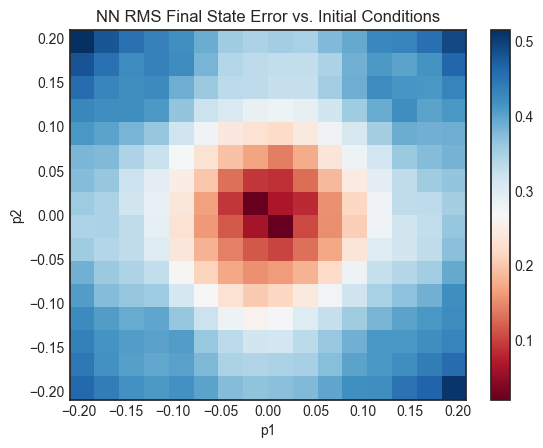

In [144]:
fig, ax = plt.subplots()
c = ax.pcolormesh(MESH_X, MESH_Y, rms_errors_torch.reshape((N_points,N_points)), cmap="RdBu")
fig.colorbar(c, ax=ax)
ax.set_xlabel(MESH_LABELS[0])
ax.set_ylabel(MESH_LABELS[1])
ax.set_title("NN RMS Final State Error vs. Initial Conditions")
plt.show()

In [145]:
def plot_state_trajectories(t_span, state_traj, desired):
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(4,1)
    labels = ["q1", "q2", "p1", "p2"]
    num_trajectories = state_traj.shape[1]
    for i in range(num_trajectories):
        for state_id in range(4):
            ax[state_id].plot(t_span, state_traj[:,i, state_id], 'b', alpha=.05)
            ax[state_id].plot(t_span, np.ones_like(state_traj[:,i, state_id])*desired[state_id], '--k', alpha=.1)
            ax[state_id].set_ylabel(labels[state_id])
            ax[state_id].grid(linestyle='--', axis='x')
    ax[-1].set_xlabel("Time (s)")
    for ax_id in range(3):
        ax[ax_id].set_xticklabels([])
    plt.show()


torch.Size([100, 256, 4])


C:\Users\kevin\AppData\Local\Temp\ipykernel_51836\3283414448.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


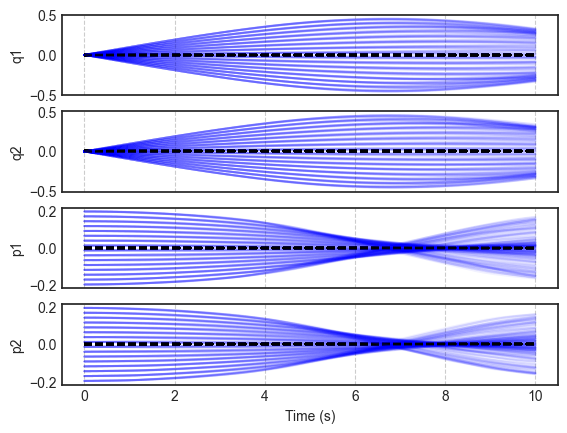

In [146]:
print(trajs.shape)
plot_state_trajectories(np.array(t_torch), np.array(trajs), sg)

C:\Users\kevin\AppData\Local\Temp\ipykernel_51836\3283414448.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


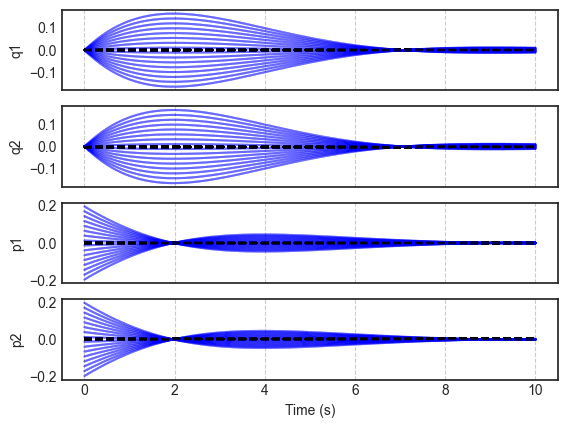

In [147]:
plot_state_trajectories(t, np.moveaxis(np.array(state_hists), 0, 1), sg)